Make sure we have a python version of 3.7 or greater:

In [ ]:
!python3 --version

Python 3.8.10


## 1 - Packages

First, let's run the cell below to import all the packages we will need.

- [numpy](https://numpy.org/doc/1.20/) is the fundamental package for scientific computing with Python

In [ ]:
!pip install numpy
!pip install tensorflow
!pip install spektral
!pip install 'networkx<2.7'

import numpy as np
import tensorflow as tf
import spektral
import json

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.1/140.1 KB 3.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 20.3 MB/s eta 0:00:00
  Attempting uninstall: networkx
    Found existing installation: networkx 3.0
    Uninstalling networkx-3.0:
      Successfully uninstalled networkx-3.0


We want access to our data which is stored in Google Drive:

In [ ]:
#Mounting Google drive so its now available to the program
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Directory where our data is stored
import os
os.chdir("/content/drive/My Drive/Colab Notebooks/data/PPI")
path = os.getcwd()

## 2 - Overview of the Problem Set

**Problem Statement:**  We are given a dataset containing:
- 24 tissues, 20 tissues in the training set, 2 in cross-validation set and 2 in the test set. Each of these tissues are represented by proteins which will be our nodes. Let's look at what information we have on these proteins in more detail:
- a training set of proteins, with each being represented as a graph node with its correspoding numerical feature vector, K-hot vector of labels, graph ID
- a cross-validation set of proteins, with each being represented as a graph node with its correspoding numerical feature vector, K-hot vector of labels, graph ID
- a test set of proteins, with each being represented as a graph node with its correspoding numerical feature vector, K-hot vector of labels, graph ID
- the structure of each human tissue, which is a graph in the test set

We will be building a Graphical Neural Network for a multi-label node (protein) classfication task.

In [ ]:
#Loading the data

#Loading training data
train_features = np.load(path + '/raw/' + 'train_feats.npy')
train_labels = np.load(path + '/raw/' + 'train_labels.npy')
train_ids = np.load(path + '/raw/' + 'train_graph_id.npy')
with open(path + '/raw/' + 'train_graph.json') as json_file:
    train_graph = json.load(json_file)

#Loading cross-validation data
valid_features = np.load(path + '/raw/' + 'valid_feats.npy')
valid_labels = np.load(path + '/raw/' + 'valid_labels.npy')
valid_ids = np.load(path + '/raw/' + 'valid_graph_id.npy')
with open(path + '/raw/' + 'valid_graph.json') as json_file:
    valid_graph = json.load(json_file)

#Loading test data
test_features = np.load(path + '/raw/' + 'test_feats.npy')
test_labels = np.load(path + '/raw/' + 'test_labels.npy')
test_ids = np.load(path + '/raw/' + 'test_graph_id.npy')
with open(path + '/raw/' + 'test_graph.json') as json_file:
    test_graph = json.load(json_file)

## 3 - Retrieve Dimensions of our Data:

In [ ]:
#Each node will have all the features we are trying to predict

m_train = train_features.shape[0]
m_valid = valid_features.shape[0]
m_test =  test_features.shape[0]


print ("Number of node training examples: m_train = " + str(m_train))
print ("Number of node cross-validation examples: m_cross = " + str(m_valid))
print ("Number of node test examples: m_test = " + str(m_test))

print ("train features shape: " + str(train_features.shape))
print(str(train_features))
print ("train labels shape: " + str(train_labels.shape))
print(str(train_labels))
print ("valid features shape: " + str(valid_features.shape))
print ("valid labels shape: " + str(valid_labels.shape))
print ("test features shape: " + str(test_features.shape))
print ("test labels shape: " + str(test_labels.shape))

Number of node training examples: m_train = 44906
Number of node cross-validation examples: m_cross = 6514
Number of node test examples: m_test = 5524
train features shape: (44906, 50)
[[-0.0855143  -0.08837446 -0.11277995 ... -0.1398976  -0.14936616
  -0.14811485]
 [-0.0855143  -0.08837446 -0.11277995 ... -0.1398976  -0.14936616
  -0.14811485]
 [-0.0855143  -0.08837446 -0.11277995 ... -0.1398976  -0.14936616
  -0.14811485]
 ...
 [-0.0855143  -0.08837446 -0.11277995 ... -0.1398976  -0.14936616
  -0.14811485]
 [-0.0855143  -0.08837446 -0.11277995 ... -0.1398976  -0.14936616
  -0.14811485]
 [-0.0855143  -0.08837446 -0.11277995 ... -0.1398976  -0.14936616
  -0.14811485]]
train labels shape: (44906, 121)
[[1 0 0 ... 1 1 0]
 [1 0 0 ... 1 1 1]
 [1 1 1 ... 0 0 0]
 ...
 [1 1 0 ... 1 1 0]
 [1 0 0 ... 1 1 1]
 [1 1 0 ... 1 1 0]]
valid features shape: (6514, 50)
valid labels shape: (6514, 121)
test features shape: (5524, 50)
test labels shape: (5524, 121)


## 4 - Class Frequency
Seeing what label classes come up the most and which come up the least

In [ ]:
#Each column in train label represent a class, we can sum this up across our nodes to get the count
#i.e. in how many nodes is this class present (how many proteins does this cellular function show up)
sum_per_column = np.sum(train_labels, axis=0)
#get the class id in order
sorted_indices = np.argsort(sum_per_column)

top_5 = sorted_indices[-5:]
bottom_5 = sorted_indices[:5]

print("Top 5 classes and count:")
for i in top_5:
    print("Class: ", i, "Count: ", sum_per_column[i])

print("\nBottom 5 classes and count:")
for i in bottom_5:
    print("Class: ", i, "Count: ", sum_per_column[i])

Top 5 classes and count:
Class:  12 Count:  31890
Class:  117 Count:  34288
Class:  118 Count:  36647
Class:  116 Count:  39828
Class:  32 Count:  39932

Bottom 5 classes and count:
Class:  86 Count:  4127
Class:  16 Count:  4651
Class:  65 Count:  5564
Class:  4 Count:  5753
Class:  77 Count:  5930


##5 - Visualisation
Experimentations to try and visualise how a graph could look like

In [ ]:
#Importing modules for graph drawing
import networkx as nx
import matplotlib.pyplot as plt

In [ ]:
#Defining an adjacency matrix from the source and target information in the json file
def adjacency_matrix(SET_graph_ids, SET_graph):

    set_ids = SET_graph_ids
    num_nodes = len(set_ids)
    set_graph = SET_graph

    num_links = len(set_graph["links"])

    adj = np.zeros((num_nodes, num_nodes))

    for i in range(num_links):
        x = set_graph["links"][i]['target']
        y = set_graph["links"][i]['source']
        adj[x, y] = adj[x, y] + 1

    #print(adj)
    return adj

In [ ]:
features = train_features
#Adjacency matrix without filtering for the different tissues
adj = adjacency_matrix(SET_graph_ids = train_ids, SET_graph = train_graph)
labels = train_labels


#to make sure everything works well with tf, use standard representation float32
features = features.astype('float32')
adj = adj.astype('float32')



print("Here is what the shape of our adjacency matrix looks like: " + str(adj.shape))

print("Here is what our adjacency matrix for the whole training data looks like: " + str(adj))


Here is what the shape of our adjacency matrix looks like: (44906, 44906)
Here is what our adjacency matrix for the whole training data looks like: [[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


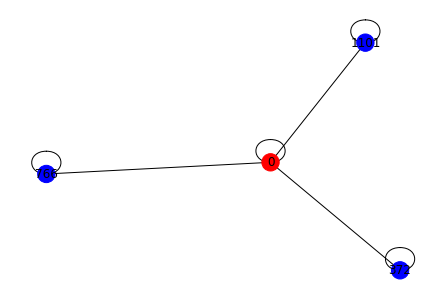

In [ ]:
#node_index = 0

#function to plot all nodes and neighbours
def plot_node_and_neighbors(adj, node_index):
    G = nx.from_numpy_array(adj)
    #a subgraph which is filtered to only the node index of interest
    subgraph = G.subgraph(list(G.neighbors(node_index)) + [node_index])
    node_color = ['red' if node == node_index else 'blue' for node in subgraph.nodes()]
    nx.draw(subgraph, with_labels=True, node_color=node_color)
    plt.show()

plot_node_and_neighbors(adj, 0)


Notice the self looping...
Going to have to remove that later

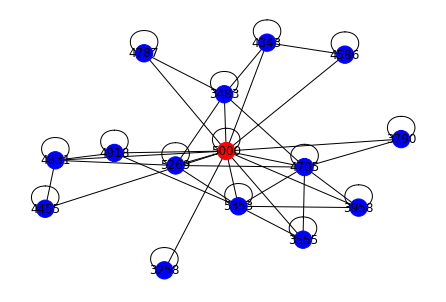

In [ ]:
plot_node_and_neighbors(adj, 5000)

The json file of the training data is to massive to double check these neighbourhoods. Hence loading the json file of the cross validation set and checking it below

In [ ]:
adj = adjacency_matrix(SET_graph_ids = valid_ids, SET_graph = valid_graph)
labels = valid_labels

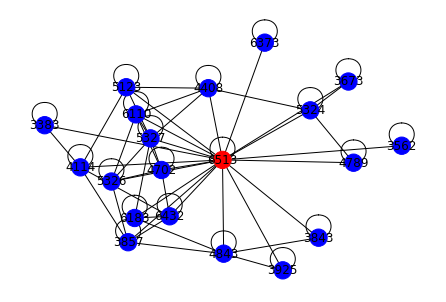

In [ ]:
plot_node_and_neighbors(adj, 6513)

Can see the neighbours of 6513 as verified in the image below:
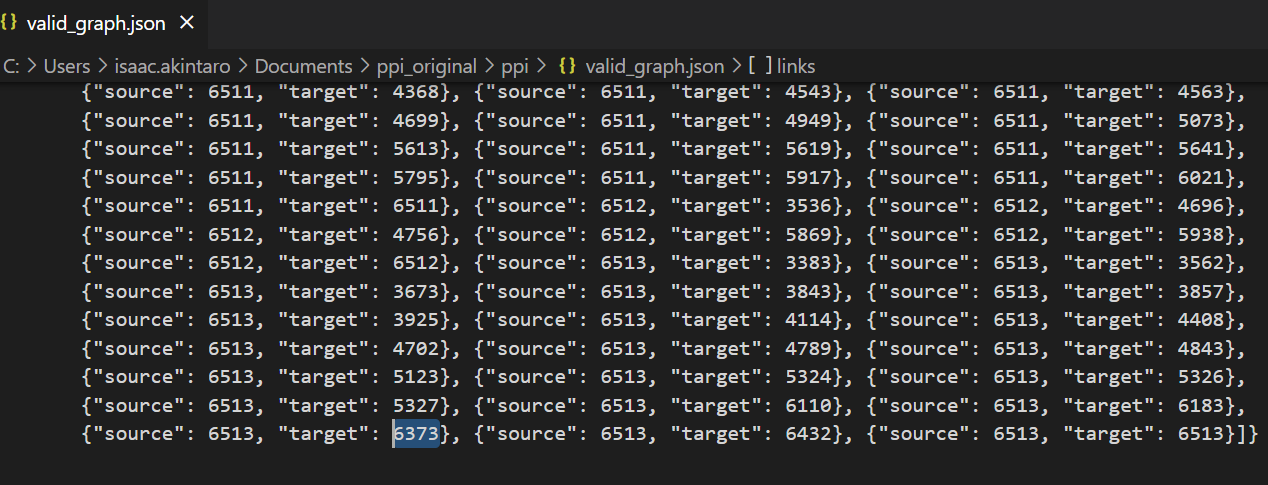